In [1]:
import random
from datetime import datetime
from typing import List, Optional
from typing import Union

import numpy as np
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image as PILImage
from torch.utils.data import DataLoader

import pyml
from diffjpeg import DiffJPEG
from models import DiscriminatorPixelMse, DiscriminatorVggMse, RandomShiftCrop

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 4
b_m = batch_size / 8

if torch.cuda.is_available():
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
srgan256_v0 = "/mnt/evo1gb/datasets/2023/srgan256_v0"
srgan256_v1 = "/mnt/evo1gb/datasets/2023/srgan256_v1"

squares_v0 = pyml.ImagesDataset.from_dirs_recursive([srgan256_v0], shuffle_seed=12, channels_order="chw")
squares_v1 = pyml.ImagesDataset.from_dirs_recursive([srgan256_v1], shuffle_seed=12, channels_order="chw")
squares_all = pyml.ImagesDataset.from_dirs_recursive([srgan256_v0, srgan256_v1], shuffle_seed=12, channels_order="chw")

batch_size = 8
data_loader_test = DataLoader(squares_v0, batch_size=batch_size, pin_memory=True, pin_memory_device='cuda')
data_loader_v1 = DataLoader(squares_v1, batch_size=batch_size, pin_memory=True, pin_memory_device='cuda')
data_loader_all = DataLoader(squares_all, batch_size=batch_size, shuffle=True, pin_memory=True,
                             pin_memory_device='cuda')

len(data_loader_test), len(data_loader_all)

(29282, 47317)

In [5]:
class RandomJPEG(nn.Module):
    def __init__(self, size: int, qualities: List[int], seed: int = 12, device: Optional[str] = None):
        super(RandomJPEG, self).__init__()
        self.jpegers = nn.ParameterList([DiffJPEG(height=size, width=size, differentiable=False, quality=q) for q in qualities])
        self.dummy = nn.Parameter(torch.zeros(size=[1]))
        self.random = random.Random(seed)

    def __call__(self, x: torch.Tensor, jpeger_no: Optional[int] = None):
        if jpeger_no is None:
            jpeger = self.random.choice(self.jpegers)
        else:
            jpeger = self.jpegers[jpeger_no]

        return jpeger(x.to(self.dummy.device)).to(x.device)


In [6]:
class GeneratorESPCN(nn.Module):
    def __init__(self, channels: int, upscale: int):
        super(GeneratorESPCN, self).__init__()
        assert upscale == 2

        self.layers = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=5, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=4, dilation=4),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=8, dilation=8),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),

            nn.Conv2d(channels, 32 * 2 ** 2, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.PixelShuffle(2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 3, kernel_size=3, padding='same'),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [7]:
class DiscriminatorDilationNetwork(nn.Module):
    def __init__(self,
                 generator_weight: float,
                 mid_channels: int):
        super(DiscriminatorDilationNetwork, self).__init__()

        self.generator_weight: float = generator_weight
        self.random_crop = RandomShiftCrop(4)

        self.layers = nn.Sequential(
            self.conv(3, mid_channels, kernel_size=5),
            self.conv(mid_channels, mid_channels, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels, mid_channels * 2, kernel_size=3),
            self.conv(mid_channels * 2, mid_channels * 2, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels * 2, mid_channels * 4, kernel_size=3),
            self.conv(mid_channels * 4, mid_channels * 4, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels * 4, mid_channels * 8, kernel_size=3),
            self.dilated_conv3(mid_channels * 8, mid_channels * 8, dilation=2),
            self.dilated_conv3(mid_channels * 8, mid_channels * 8, dilation=4),
            self.conv(mid_channels * 8, mid_channels * 8, kernel_size=3),

            self.conv(mid_channels * 8, mid_channels * 16, kernel_size=1),
            self.conv(mid_channels * 16, mid_channels, kernel_size=1),
            nn.Conv2d(mid_channels, 1, kernel_size=1)
        )

        self.binary_crossentropy_with_sigmoid = torch.nn.BCEWithLogitsLoss()

    def conv(self, in_ch: int, out_ch: int, kernel_size: int = 3) -> torch.nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def dilated_conv3(self, in_ch: int, out_ch: int, *, dilation: int) -> torch.nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, dilation=dilation, padding=dilation, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def loss_for_discriminator(self,
                               y: torch.Tensor,
                               label: torch.Tensor) -> torch.Tensor:
        y, label = self.random_crop(y, label)

        diff = self(y) - self(label)
        # realness(label) should be >> realness(y)
        zeros = torch.zeros(size=diff.size()).to(diff.device)
        return self.binary_crossentropy_with_sigmoid(diff, zeros)

    def loss(self,
             y: torch.Tensor,
             label: torch.Tensor) -> torch.Tensor:
        if self.generator_weight == 0.0:
            return torch.zeros(size=[1], device=y.get_device())

        y, label = self.random_crop(y, label)

        pred_y = self(y)
        pred_label = self(label)
        y_more_real = pred_y > pred_label

        diff = y_more_real * 9000 + ~y_more_real * (pred_y - pred_label)
        ones = torch.ones(size=diff.size()).to(diff.device)
        return self.binary_crossentropy_with_sigmoid(diff, ones) * self.generator_weight

    def forward(self, y: torch.Tensor) -> torch.Tensor:
        y = self.layers(y)
        return y

In [8]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 2
        self.generator = GeneratorESPCN(channels=128, upscale=scale).to(self.device)

        self.d_pixel_mse = DiscriminatorPixelMse(weight=1.0)
        self.d_vgg_mse = DiscriminatorVggMse(weight=0.0001, inpad_size=0).to(self.device)
        self.d_vgg_mse_x2 = DiscriminatorVggMse(weight=0.0001, prescale=2, inpad_size=0).to(self.device)
        self.d_baseline = DiscriminatorDilationNetwork(generator_weight=0.001, mid_channels=32).to(self.device)

        self.jpeger = RandomJPEG(size=256 // scale, qualities=[50, 70, 80, 90, 95, 99]).to(self.device)
        self.losses = []
        self.losses_print_step = 1000

    def add_loss(self, losses: List[torch.Tensor]):
        self.losses.append([loss.item() for loss in losses])
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(np.array(self.losses[-self.losses_print_step:]), axis=0)
            print(f"{len(self.losses)}: {av_loss}")

    def generate_data(self):
        while True:
            for label in self.data_loader:
                yield label

    def downsample(self, x: torch.Tensor, factor: int) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h // factor, w // factor), mode='bilinear', antialias=True)

    def upsample(self, x: torch.Tensor, factor: int) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h * factor, w * factor), mode='bilinear')

    def train(self, *, steps: int, lr_g: float = 0.0, lr_d: float = 0.0):
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr_g)
        discriminator_optimizer = torch.optim.Adam(self.d_baseline.parameters(), lr=lr_d)

        self.generator.train()
        self.d_baseline.train()

        for step, label in zip(range(steps), self.generate_data()):
            label = label.to(self.device)
            label.requires_grad = False

            x = self.downsample(label, 2)
            x = self.jpeger(x)

            saved_y: Optional[torch.Tensor] = None

            # train generator
            if lr_g != 0.0:
                generator_optimizer.zero_grad()
                y = self.generator(x)
                saved_y = y.detach()

                g_losses = [f.loss(y, label) for f in
                            [self.d_pixel_mse, self.d_vgg_mse, self.d_vgg_mse_x2, self.d_baseline]]
                loss = sum(g_losses)
                loss.backward()
                generator_optimizer.step()
            else:
                g_losses = [torch.zeros(size=[1], device=self.device) for _ in range(4)]

            # train discriminator
            if lr_d != 0.0:
                discriminator_optimizer.zero_grad()
                y = saved_y if saved_y is not None else self.generator(x).detach()
                d_loss = self.d_baseline.loss_for_discriminator(y, label)
                d_loss.backward()
                discriminator_optimizer.step()
            else:
                d_loss = torch.zeros(size=[1], device=self.device)

            self.add_loss(g_losses + [d_loss])

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor], jpeger_no: Optional[int] = None) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        scale = 2
        self.generator.eval()
        x = self.downsample(label, scale)
        if jpeger_no is not None:
            x = self.jpeger(x, jpeger_no)

        y = self.generator(x)
        x4x = self.upsample(x, scale)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        torch.save(self.d_baseline.state_dict(), f"models/espcn/discriminator_baseline_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))
        self.d_baseline.load_state_dict(torch.load(f"models/espcn/discriminator_baseline_{suffix}.pth"))

In [9]:
gan_helper = GanHelper(data_loader_all)

/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [10]:
gan_helper.train(steps=100 * 1000 // batch_size, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m)

1000: [0.02204142 0.00759142 0.00858322 0.00155257 0.25630597]
2000: [0.00367429 0.0054804  0.00429176 0.00227304 0.11304916]
3000: [0.002348   0.0044229  0.00278693 0.00279536 0.06700896]
4000: [0.0019285  0.00412    0.00229439 0.00305921 0.0676496 ]
5000: [0.00160871 0.00387898 0.00203936 0.0038198  0.02419175]
6000: [0.00167271 0.00385719 0.00196835 0.00377622 0.05306613]
7000: [0.0019973  0.00426446 0.00207605 0.00255971 0.18298951]
8000: [0.00210016 0.00428124 0.00210301 0.00231756 0.21052087]
9000: [0.0019856  0.00420993 0.00206367 0.00283528 0.15648918]
10000: [0.00197606 0.00423762 0.00206784 0.0031508  0.12120173]
11000: [0.00184801 0.00402736 0.00198001 0.00396532 0.06849506]
12000: [0.00177595 0.00395764 0.00194801 0.0043256  0.05165856]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


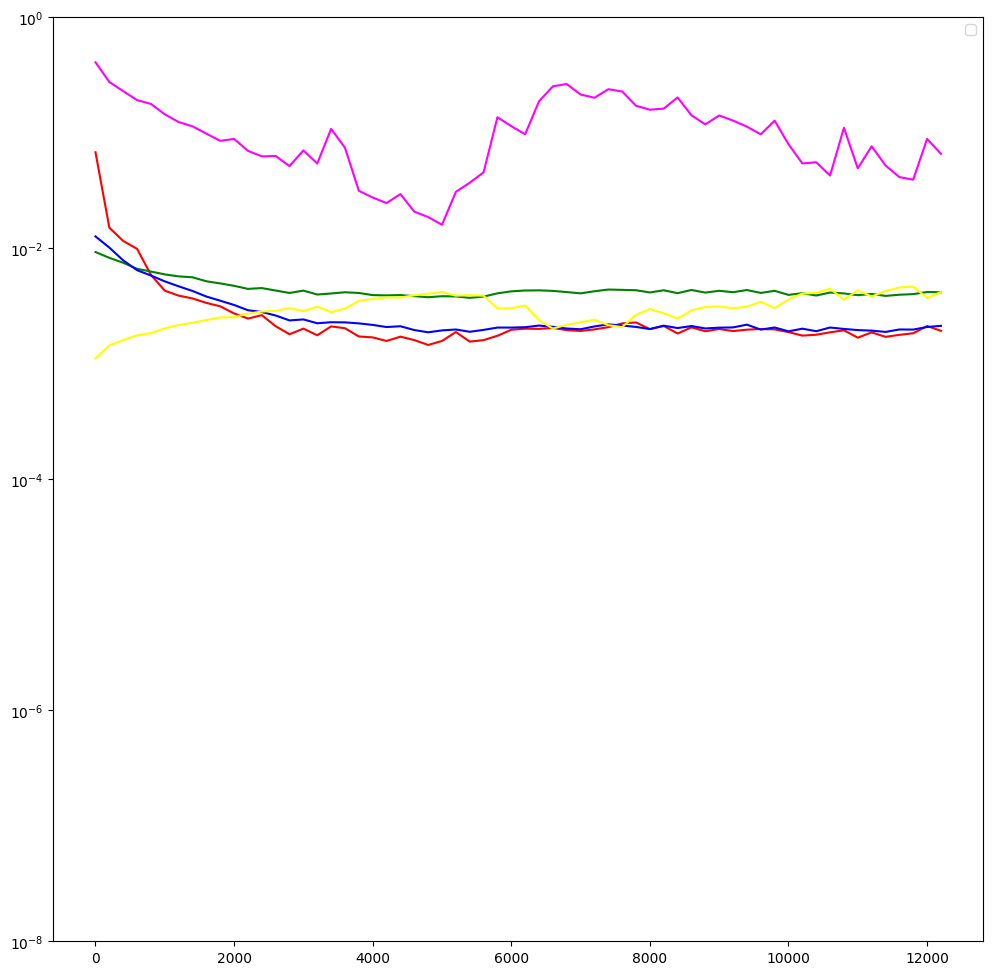

In [11]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(0.00000001, 1)


def my_plot(lst: List[float], av: int):
    for i, color in enumerate(["red", "green", "blue", "yellow", "magenta"]):
        arr = np.array(lst)[:, i]
        arr = arr[:arr.shape[0] // av * av]
        arr = arr.reshape(-1, av).mean(axis=1)
        ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)


my_plot(gan_helper.losses, av=200)

ax.legend()
plt.show()

In [12]:
gan_helper.train(steps=100 * 1000 // batch_size, lr_g=0.00003 * b_m, lr_d=0.00003 * b_m)
gan_helper.train(steps=100 * 1000 // batch_size, lr_g=0.000001 * b_m, lr_d=0.000001 * b_m)

13000: [0.0018837  0.00410915 0.0020244  0.00411567 0.07561486]
14000: [0.00183013 0.00415566 0.00205338 0.0052755  0.02952084]
15000: [0.00170248 0.0040018  0.00197791 0.00534167 0.0334551 ]
16000: [0.0017116  0.00404597 0.00196722 0.00504475 0.04059249]
17000: [0.0016849  0.00401583 0.00194536 0.00540015 0.03023626]
18000: [0.00169065 0.0039958  0.00193173 0.00513507 0.03953857]
19000: [0.00174356 0.00403935 0.00195201 0.00513458 0.04777715]
20000: [0.001726   0.00401951 0.00196769 0.00529401 0.03348585]
21000: [0.00171308 0.00401165 0.00196857 0.00530572 0.03981008]
22000: [0.00176756 0.00412693 0.00203711 0.00602225 0.02073857]
23000: [0.00182152 0.00408508 0.00197244 0.00517284 0.04669319]
24000: [0.00173714 0.00403322 0.00193246 0.00569198 0.0328987 ]
25000: [0.0016826  0.0039648  0.00195301 0.00561346 0.03605421]
26000: [0.00171802 0.00412137 0.00203635 0.00532929 0.04435512]
27000: [0.00177339 0.004149   0.0020331  0.00573547 0.03253555]
28000: [0.00172133 0.00411685 0.00200847

In [13]:
model_suffix = gan_helper.save_model()
model_suffix

'2023-05-11-05-44-54'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


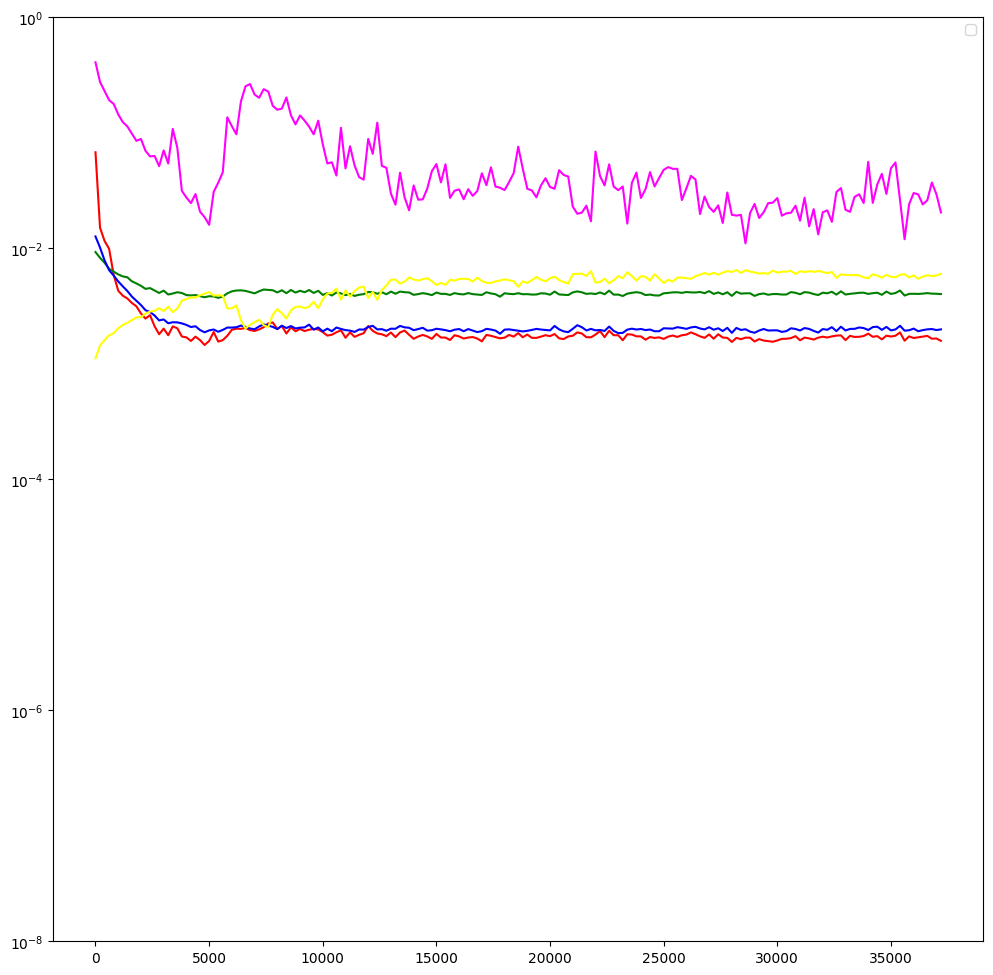

In [14]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(0.00000001, 1)


def my_plot(lst: List[float], av: int):
    for i, color in enumerate(["red", "green", "blue", "yellow", "magenta"]):
        arr = np.array(lst)[:, i]
        arr = arr[:arr.shape[0] // av * av]
        arr = arr.reshape(-1, av).mean(axis=1)
        ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)


my_plot(gan_helper.losses, av=200)

ax.legend()
plt.show()

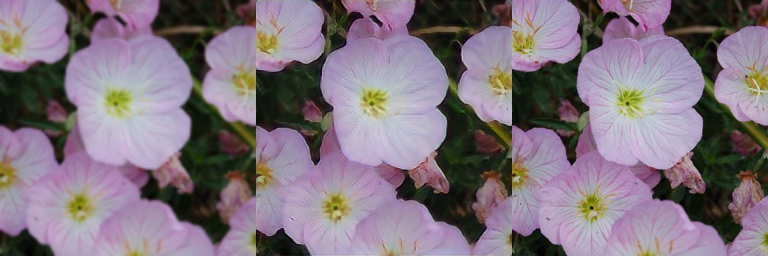

In [15]:
gan_helper.demonstrate(dataset[0])

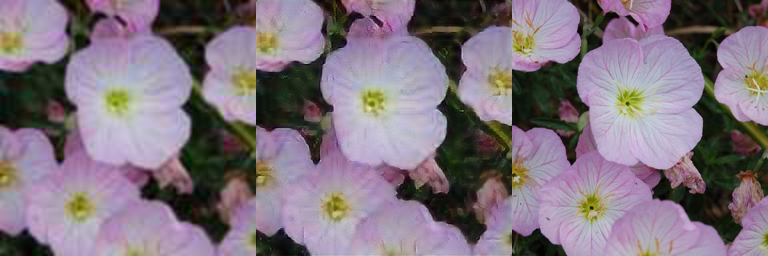

In [16]:
gan_helper.demonstrate(dataset[0], jpeger_no=0)

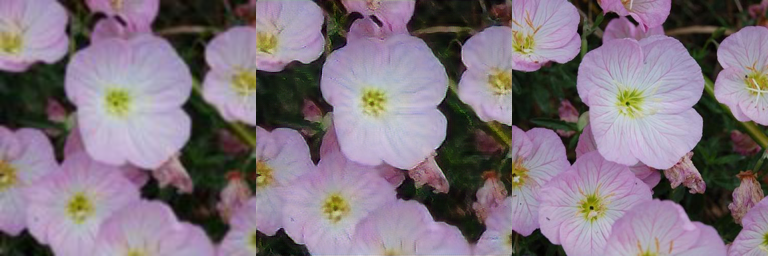

In [17]:
gan_helper.demonstrate(dataset[0], jpeger_no=2)

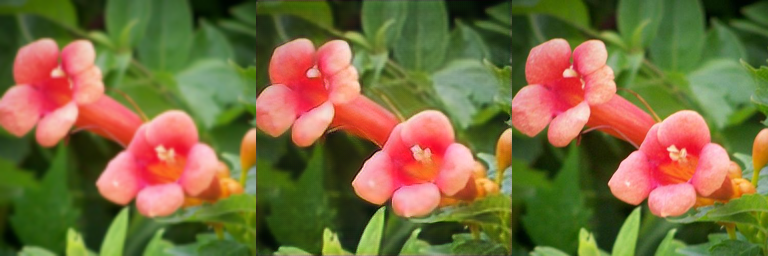

In [18]:
gan_helper.demonstrate(dataset[6])

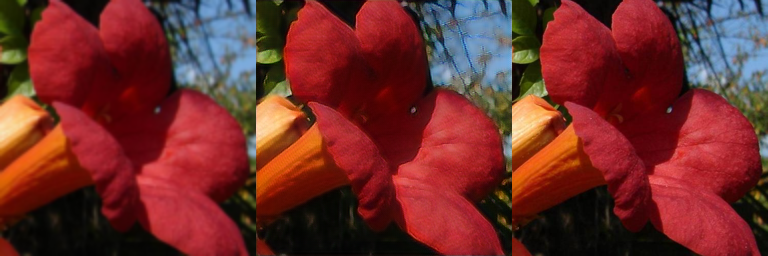

In [19]:
gan_helper.demonstrate(dataset[7])

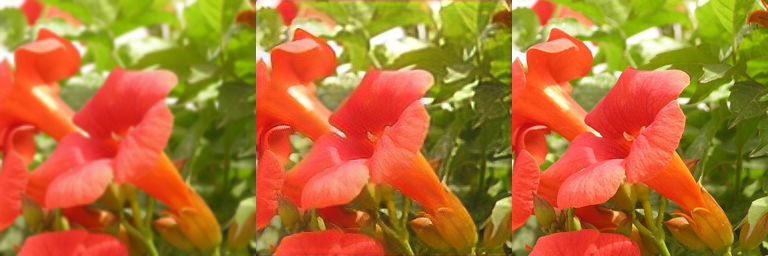

In [20]:
gan_helper.demonstrate(dataset[8])

In [22]:
g = GeneratorESPCN(channels=128, upscale=2)
g.load_state_dict(torch.load(f"models/espcn/generator_espcn_{model_suffix}.pth"))
g.to('cpu')

saver = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-pics')

demo_data = pyml.ImagesDataset.from_dirs_recursive(
    roots=["/mnt/pi8-v2/mnt/safedata/datasets/2020/torrent/windows"],
    shuffle_seed=12,
    channels_order='chw'
)

for i in range(500):
    src = demo_data[i]
    if src is None:
        continue
    if src.shape[1] > 1280 or src.shape[2] > 1280:
        continue

    batch = torch.from_numpy(src[np.newaxis])
    y = g(batch)
    saver.saveCHW(src)
    saver.saveCHW(y.detach().numpy()[0])
    print(".", end='.')

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [23]:
import PIL.ImageOps

saver2 = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-pics-l')

for i in range(1000):
    src = demo_data[i]
    if src is None:
        continue
    if src.shape[1] <= 1280 and src.shape[2] <= 1280:
        continue
    pil_image = PILImage.open(demo_data.images_paths[i])
    pil_image = PIL.ImageOps.exif_transpose(pil_image)
    pil_image = pil_image.convert('RGB')
    w, h = pil_image.size
    k = 512.0 / max(h, w)
    pil_image = pil_image.resize(size=(int(w * k), int(h * k)))

    np_array = np.asarray(pil_image).astype(np.float32) / 255.0
    np_array = np.moveaxis(np_array, 2, 0)

    batch = torch.from_numpy(np_array[np.newaxis])
    y = g(batch)
    saver2.saveCHW(np_array)
    saver2.saveCHW(y.detach().numpy()[0])
    print(".", end='.')

..................................................................................................................................................................................................................................................................................................................................................................................................